In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [105]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_ids = test_df['Id'].copy()


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [3]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 50.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 77.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: graphql-core
    Found existing installation: graphql-core 3.2.6
    Uninstalling graphql-core-3.2.6:
      Successfully uninstalled graphql-core-3.2.6
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.2 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import dagshub
import mlflow

# Data Preprocessing and Correlation Handling

In [18]:
dagshub.init(repo_owner='mkoko22', repo_name='mkoko22-ML-1', mlflow=True)

Initialized MLflow to track repo "mkoko22/mkoko22-ML-1"

Repository mkoko22/mkoko22-ML-1 initialized!

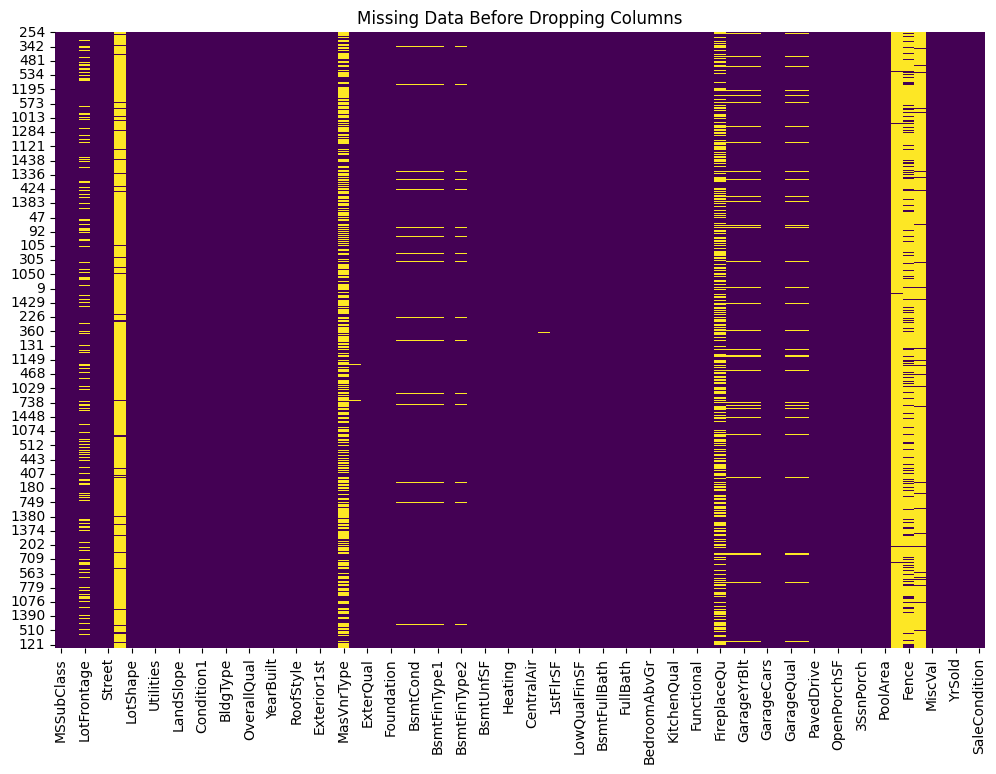

Dropping columns with more than 50.0% missing values: ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


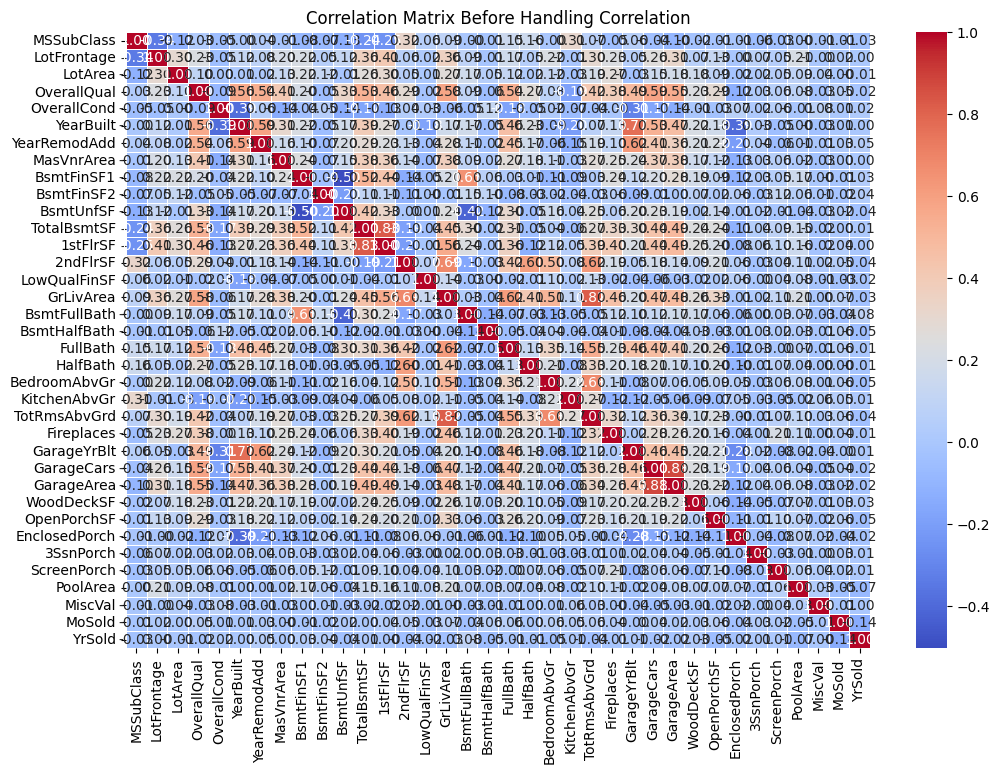

Original X_train shape: (1168, 72)
Updated X_train shape after dropping correlated features: (1168, 72)
Original X_test shape: (292, 72)
Processed test_df shape: (1459, 73)


In [106]:
def handle_correlation(X_train, X_test, numerical_cols, threshold=0.85):
    corr_matrix = X_train[numerical_cols].corr()
    high_corr_var = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_var.add(corr_matrix.columns[i])
                high_corr_var.add(corr_matrix.columns[j])

    X_train = X_train.drop(columns=high_corr_var)
    X_test = X_test.drop(columns=high_corr_var)

    return X_train, X_test, high_corr_var  # Return high_corr_var so we can handle it for the test set


def plot_missing_data(df, title="Missing Data Heatmap"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.isna(), cbar=False, cmap='viridis', cbar_kws={'label': 'Missing Values'})
    plt.title(title)
    plt.show()

def plot_correlation_matrix(df, numerical_cols, title="Correlation Matrix"):
    plt.figure(figsize=(12, 8))
    corr_matrix = df[numerical_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title)
    plt.show()

def preprocess_data(df, test_df, target_column='SalePrice', test_size=0.2, missing_threshold=0.5, correlation_threshold=0.85):
    
    df = df.drop(columns=['Id']) if 'Id' in df.columns else df
    test_df = test_df.drop(columns=['Id']) if 'Id' in test_df.columns else test_df

    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    plot_missing_data(X_train, title="Missing Data Before Dropping Columns")

    missing_cols = X_train.columns[X_train.isna().mean() > missing_threshold]
    print(f"Dropping columns with more than {missing_threshold * 100}% missing values: {missing_cols.tolist()}")
    X_train = X_train.drop(columns=missing_cols)
    X_test = X_test.drop(columns=missing_cols)
    test_df_processed = test_df.drop(columns=[col for col in missing_cols if col in test_df.columns])

    numerical_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']
    categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

    numerical_imputer = SimpleImputer(strategy='median')
    X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])
    test_df_processed[numerical_cols] = numerical_imputer.transform(test_df_processed[numerical_cols])

    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
    X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])
    test_df_processed[categorical_cols] = categorical_imputer.transform(test_df_processed[categorical_cols])

    plot_correlation_matrix(X_train, numerical_cols, title="Correlation Matrix Before Handling Correlation")

    X_train, X_test, high_corr_var = handle_correlation(X_train, X_test, numerical_cols, correlation_threshold)
    test_df_processed = test_df_processed.drop(columns=[col for col in high_corr_var if col in test_df_processed.columns])

    print(f"Original X_train shape: {X_train.shape}")
    print(f"Updated X_train shape after dropping correlated features: {X_train.shape}")
    print(f"Original X_test shape: {X_test.shape}")
    print(f"Processed test_df shape: {test_df_processed.shape}")

    return X_train, X_test, y_train, y_test, test_df_processed


X_train, X_test, y_train, y_test, test_df_processed = preprocess_data(
    train_df, 
    test_df,
    target_column='SalePrice',
    test_size=0.2,
    missing_threshold=0.5,
    correlation_threshold=0.85
)


In [93]:
train_df.shape

(1460, 81)

In [95]:
numerical_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical columns: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedD

#  Outlier Detection and Capping


Outlier Summary:
                outlier_count  outlier_percentage
MSSubClass              84.0            7.191781
LotFrontage             85.0            7.277397
LotArea                 54.0            4.623288
OverallQual              2.0            0.171233
OverallCond             99.0            8.476027
YearBuilt                5.0            0.428082
YearRemodAdd             0.0            0.000000
MasVnrArea              77.0            6.592466
BsmtFinSF1               5.0            0.428082
BsmtFinSF2             131.0           11.215753
BsmtUnfSF               21.0            1.797945
TotalBsmtSF             47.0            4.023973
1stFlrSF                13.0            1.113014
2ndFlrSF                 1.0            0.085616
LowQualFinSF            21.0            1.797945
GrLivArea               23.0            1.969178
BsmtFullBath             1.0            0.085616
BsmtHalfBath            66.0            5.650685
FullBath                 0.0            0.000000
H

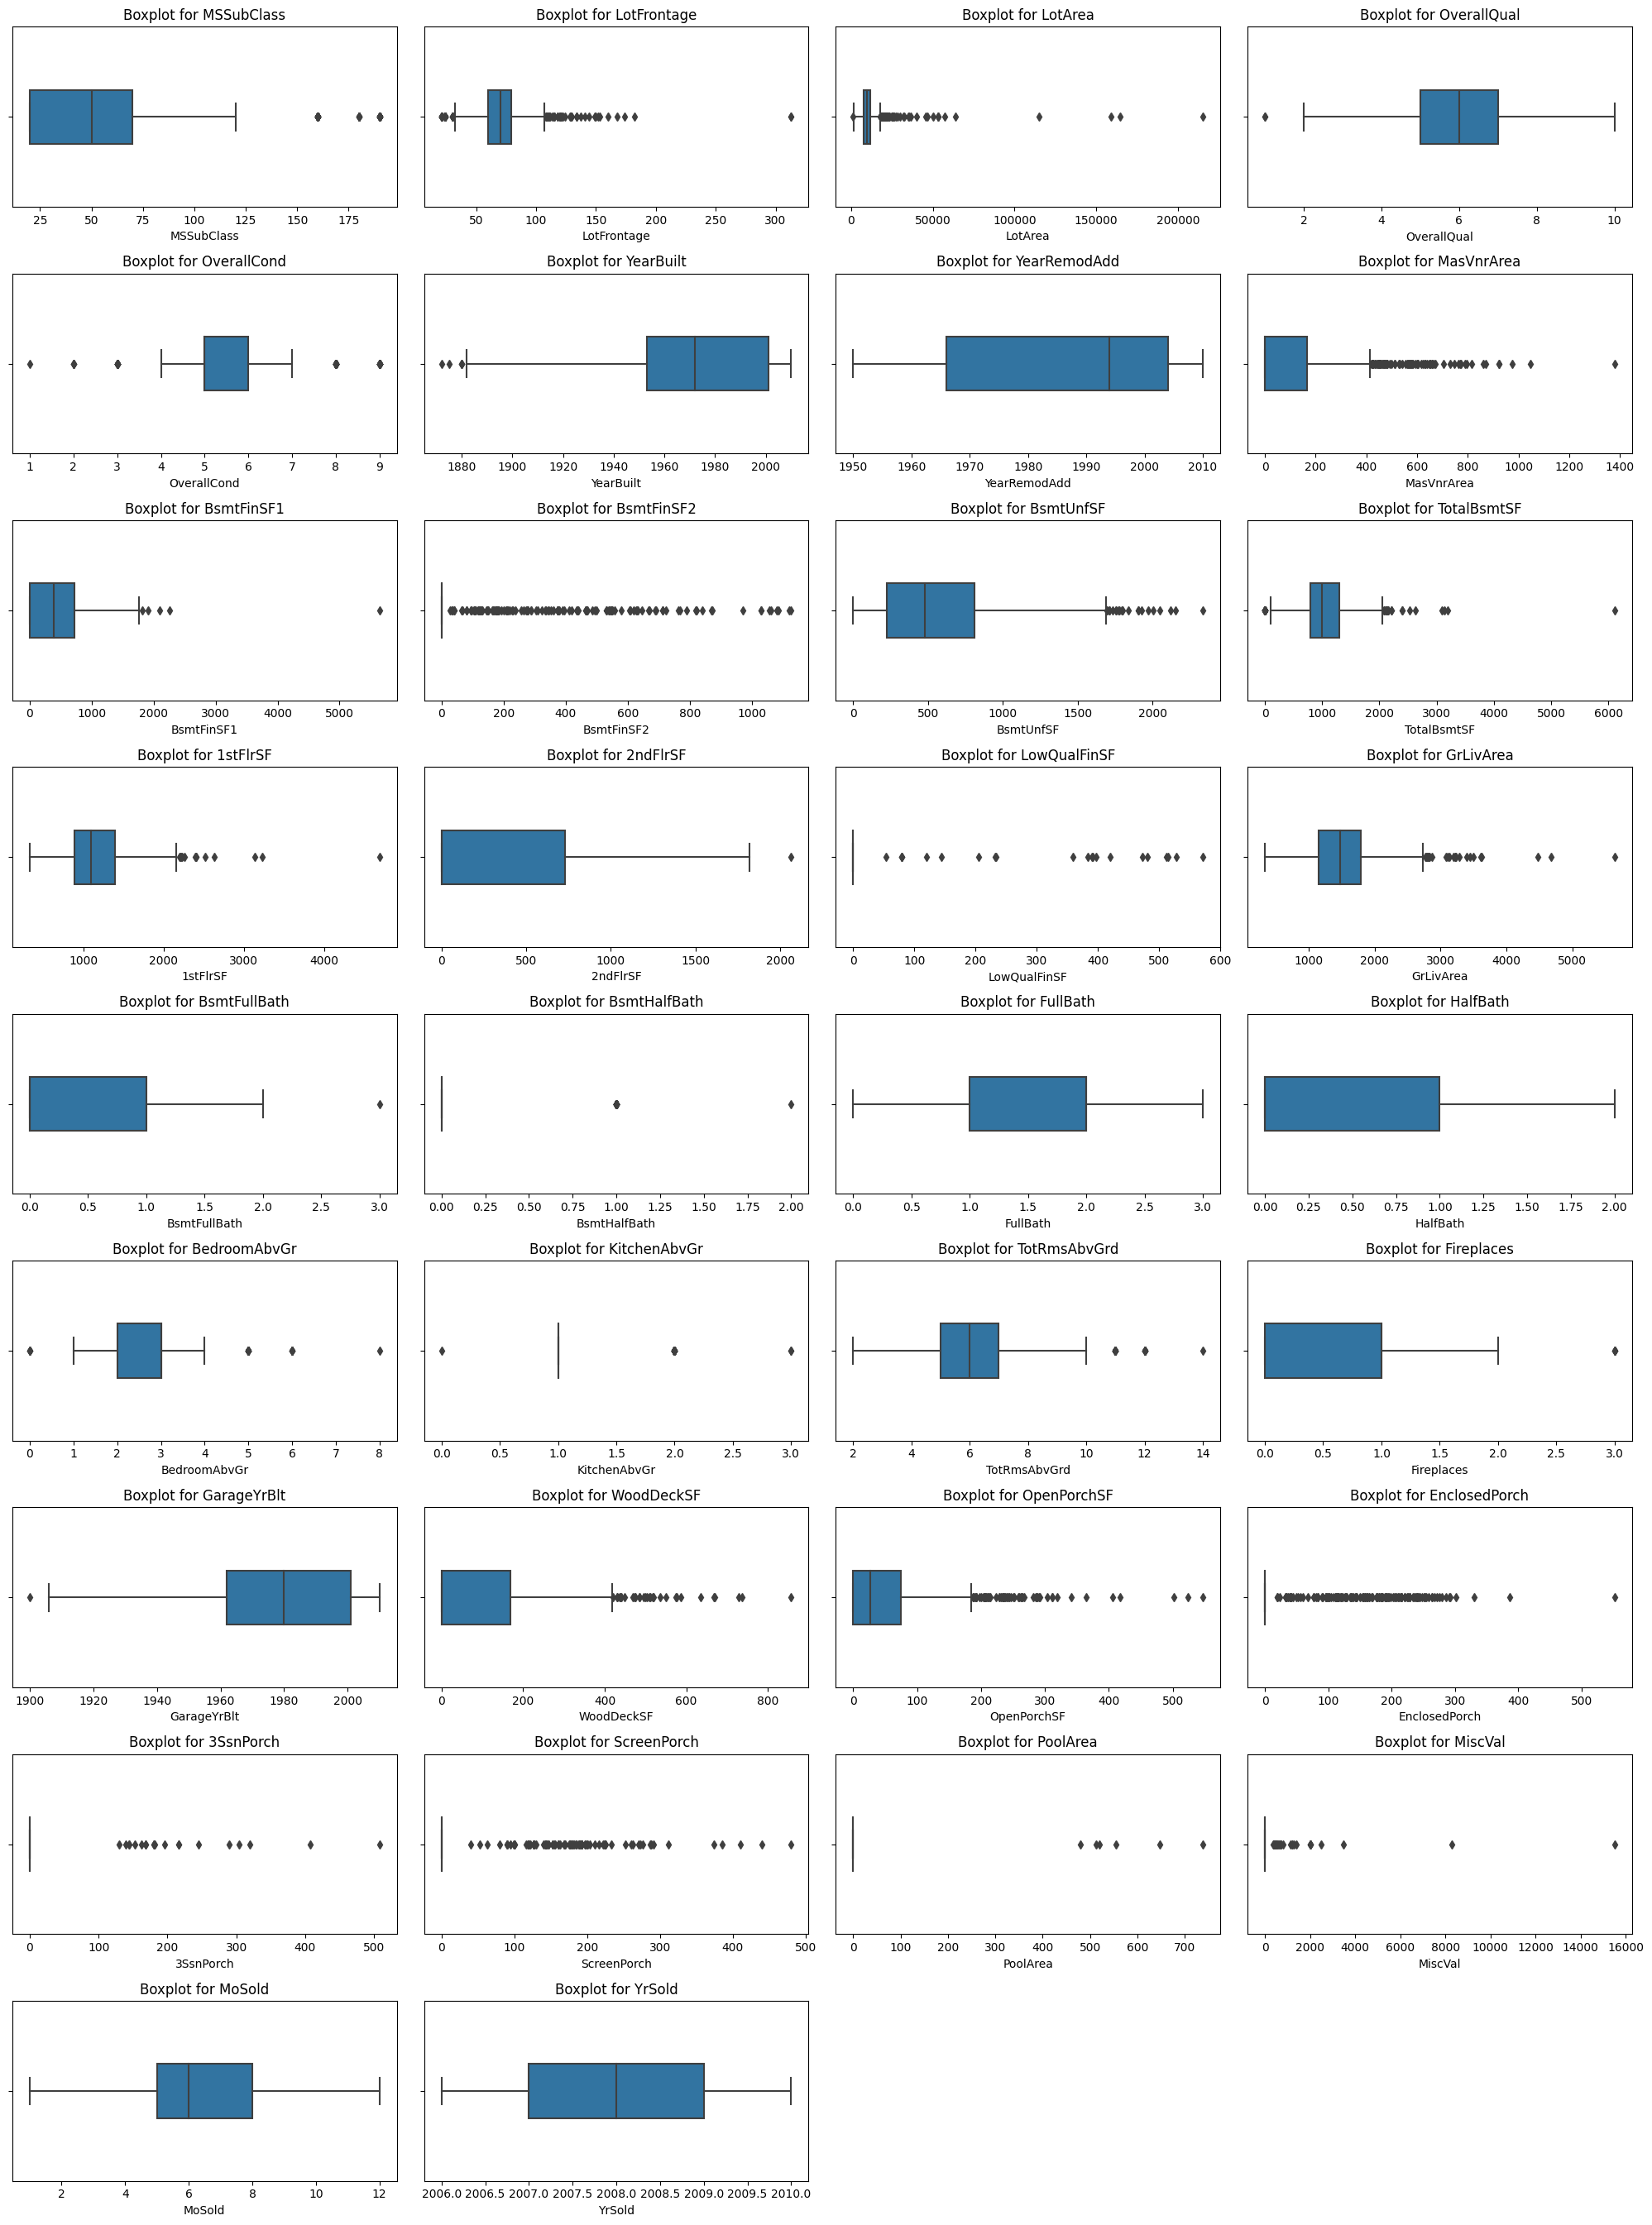

In [96]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def detect_outliers(df, numerical_cols, threshold=5):
    outlier_info = {}

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        outlier_count = outliers.shape[0]
        outlier_percentage = outlier_count / df.shape[0] * 100
        
        outlier_info[col] = {
            'outlier_count': outlier_count,
            'outlier_percentage': outlier_percentage
        }

    outlier_summary = pd.DataFrame(outlier_info).T  
    return outlier_summary

def plot_outliers(df, numerical_cols):
    num_plots = len(numerical_cols)
    num_columns = 4
    num_rows = (num_plots + num_columns - 1) // num_columns 
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        sns.boxplot(x=df[col], width=0.3, ax=axes[i])
        axes[i].set_title(f'Boxplot for {col}')

    for i in range(num_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    
def handle_outliers(df, outlier_summary, features_to_handle):
    for col in features_to_handle:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
       
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = np.clip(df[col], lower_bound, upper_bound)
        print(f"Capped outliers in {col} within the range ({lower_bound}, {upper_bound})")

    return df

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
outlier_summary = detect_outliers(X_train, numerical_cols)

print("\nOutlier Summary:\n", outlier_summary)
plot_outliers(X_train, numerical_cols)

features_to_handle = outlier_summary[outlier_summary['outlier_percentage'] > 5].index.tolist()
X_train = handle_outliers(X_train, outlier_summary, features_to_handle)
X_test = handle_outliers(X_test, outlier_summary, features_to_handle)

X_test_processed = handle_outliers(test_df_processed, outlier_summary, features_to_handle)


# One HOT Encoding

In [98]:
import pandas as pd

def encode_categorical_columns(X_train, X_test, test_df):
    categorical_cols = X_train.select_dtypes(include=['object']).columns

    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
    _, test_df_encoded = X_train_encoded.align(test_df_encoded, join='left', axis=1, fill_value=0)

    for df in [X_train_encoded, X_test_encoded, test_df_encoded]:
        bool_cols = df.select_dtypes(include=['bool']).columns
        df[bool_cols] = df[bool_cols].astype('int64')

    print(f"X_train_encoded shape: {X_train_encoded.shape}")
    print(f"X_test_encoded shape: {X_test_encoded.shape}")
    print(f"test_df_encoded shape: {test_df_encoded.shape}")

    return X_train_encoded, X_test_encoded, test_df_encoded

X_train_encoded, X_test_encoded, test_df_encoded = encode_categorical_columns(X_train, X_test, test_df_processed)

X_train_encoded shape: (1168, 229)
X_test_encoded shape: (292, 229)
test_df_encoded shape: (1459, 229)


### Constant features/ Low variance/ Highly correlated

X_train shape after removing constant features: (1168, 225)
X_test shape after removing constant features: (292, 225)
test_df shape after removing constant features: (1459, 225)
X_train shape after removing quasi-constant features: (1168, 97)
X_test shape after removing quasi-constant features: (292, 97)
test_df shape after removing quasi-constant features: (1459, 97)
X_train shape after removing highly correlated features: (1168, 88)
X_test shape after removing highly correlated features: (292, 88)
test_df shape after removing highly correlated features: (1459, 88)


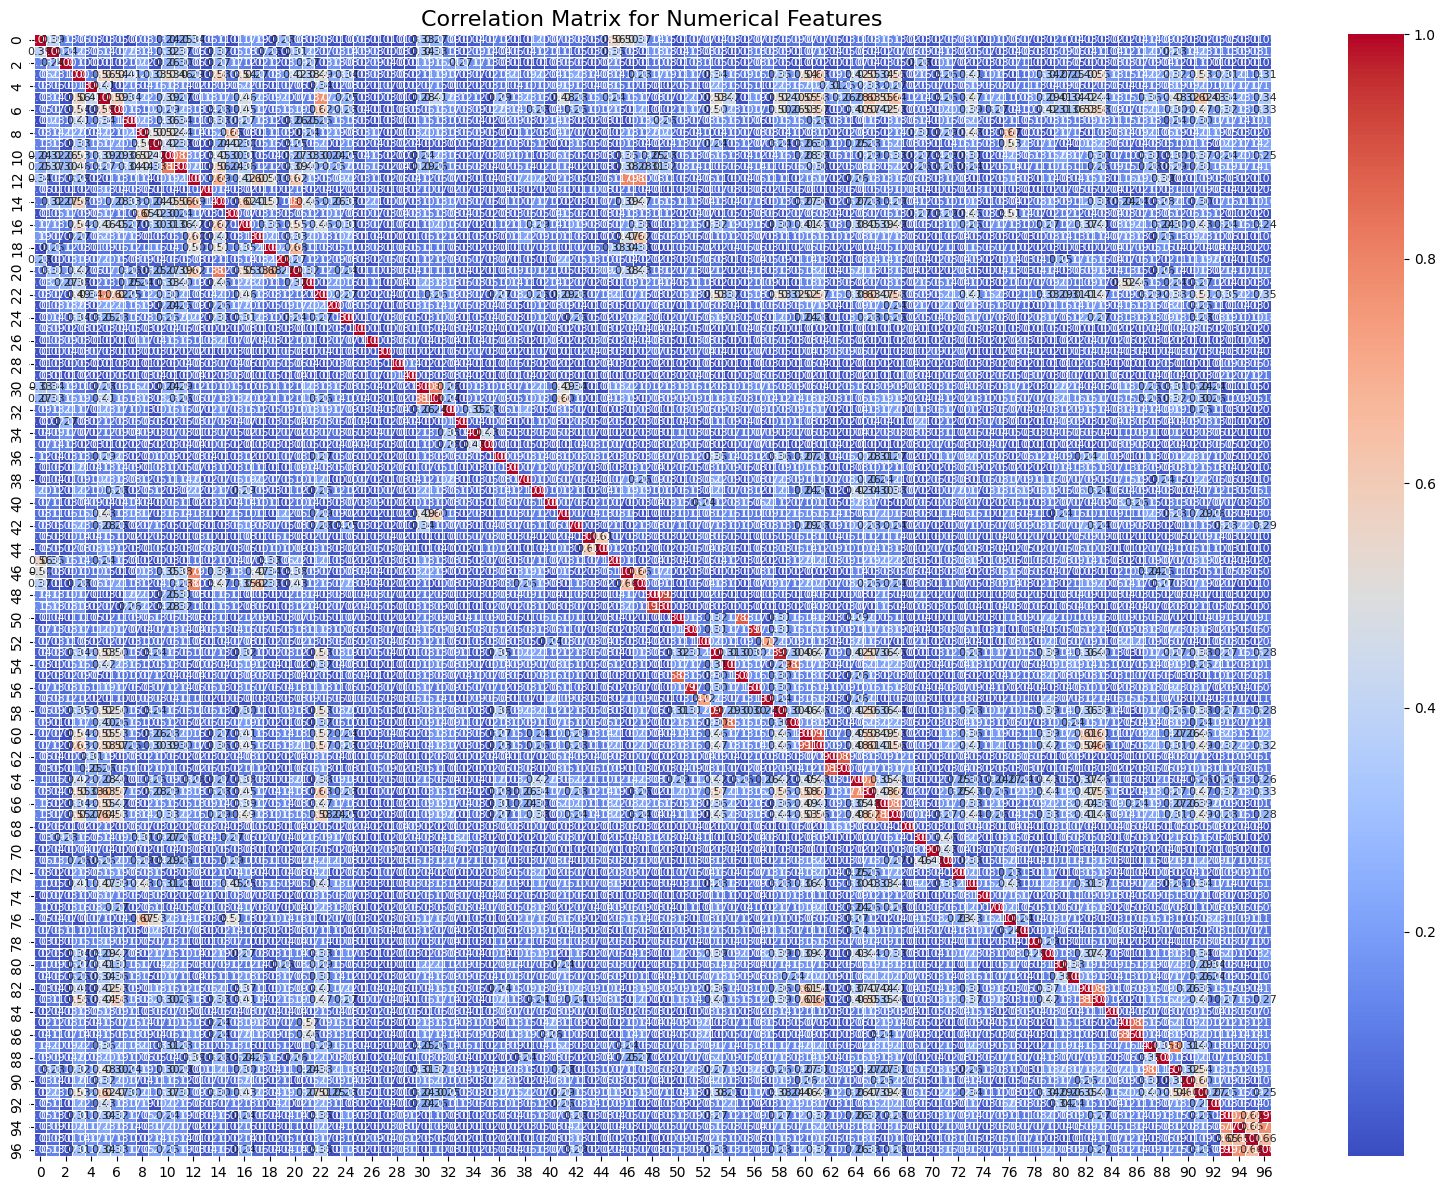

In [100]:
from sklearn.feature_selection import VarianceThreshold

def preprocess_features(X_train, X_test, test_df, correlation_threshold=0.85, quasi_constant_threshold=0.05):
   
    constant_filter = VarianceThreshold(threshold=0)
    X_train_reduced = constant_filter.fit_transform(X_train)
    X_test_reduced = constant_filter.transform(X_test)
    test_df_reduced = constant_filter.transform(test_df)

    print(f"X_train shape after removing constant features: {X_train_reduced.shape}")
    print(f"X_test shape after removing constant features: {X_test_reduced.shape}")
    print(f"test_df shape after removing constant features: {test_df_reduced.shape}")

  
    quasi_constant_filter = VarianceThreshold(threshold=quasi_constant_threshold)
    X_train_reduced = quasi_constant_filter.fit_transform(X_train_reduced)
    X_test_reduced = quasi_constant_filter.transform(X_test_reduced)
    test_df_reduced = quasi_constant_filter.transform(test_df_reduced)

    print(f"X_train shape after removing quasi-constant features: {X_train_reduced.shape}")
    print(f"X_test shape after removing quasi-constant features: {X_test_reduced.shape}")
    print(f"test_df shape after removing quasi-constant features: {test_df_reduced.shape}")

    
    corr_matrix = pd.DataFrame(X_train_reduced).corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).fillna(0)

    highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

    X_train_reduced = pd.DataFrame(X_train_reduced).drop(columns=highly_correlated)
    X_test_reduced = pd.DataFrame(X_test_reduced).drop(columns=highly_correlated)
    test_df_reduced = pd.DataFrame(test_df_reduced).drop(columns=highly_correlated)

    print(f"X_train shape after removing highly correlated features: {X_train_reduced.shape}")
    print(f"X_test shape after removing highly correlated features: {X_test_reduced.shape}")
    print(f"test_df shape after removing highly correlated features: {test_df_reduced.shape}")

    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
    plt.title("Correlation Matrix for Numerical Features", fontsize=16)
    plt.tight_layout()
    plt.show()

    return X_train_reduced, X_test_reduced, test_df_reduced


X_train_reduced, X_test_reduced, test_df_reduced = preprocess_features(X_train_encoded, X_test_encoded, test_df_encoded)


## Check data

In [70]:
duplicates_train = X_train_reduced.duplicated().sum()
duplicates_test = X_test_reduced.duplicated().sum()

print(f"Duplicates in X_train: {duplicates_train}")
print(f"Duplicates in X_test: {duplicates_test}")

Duplicates in X_train: 0
Duplicates in X_test: 0


In [71]:
print(f"Final number of features in X_train: {X_train_reduced.shape[1]}")
print(f"Final number of features in X_test: {X_test_reduced.shape[1]}")

Final number of features in X_train: 88
Final number of features in X_test: 88


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


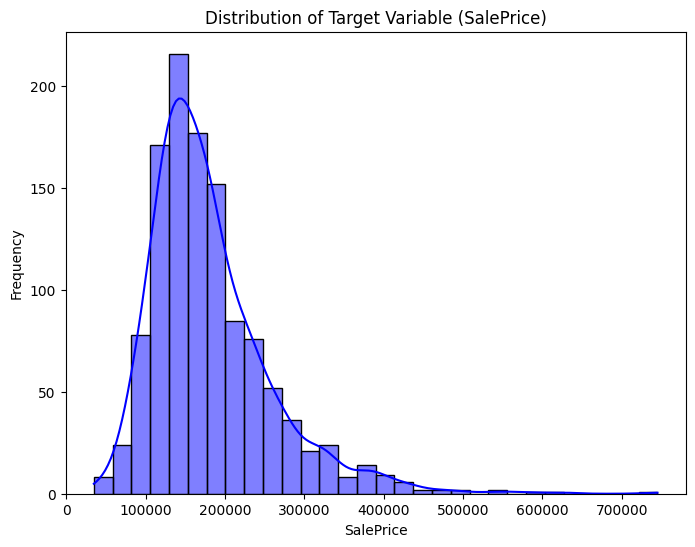

In [54]:
plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True, bins=30, color='blue')
plt.title("Distribution of Target Variable (SalePrice)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

### Data Scaling

In [101]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_features(X_train_reduced, X_test_reduced, test_df_reduced):
   
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train_reduced)

    X_test_scaled = scaler.transform(X_test_reduced)
    test_df_scaled = scaler.transform(test_df_reduced)

    print(f"Mean of scaled data (should be ~0) for X_train:\n{np.mean(X_train_scaled, axis=0)}")
    print(f"Standard deviation of scaled data (should be ~1) for X_train:\n{np.std(X_train_scaled, axis=0)}")

    return X_train_scaled, X_test_scaled, test_df_scaled, scaler
    
X_train_scaled, X_test_scaled, test_df_scaled, scaler = scale_features(X_train_reduced, X_test_reduced, test_df_reduced)


Mean of scaled data (should be ~0) for X_train:
[-5.47507245e-17  2.25086312e-16  2.28128019e-17 -4.25838968e-17
 -3.61963123e-16 -1.42047713e-15  4.64164476e-15 -7.30009660e-17
  1.52085346e-17  4.86673107e-17  2.03794363e-16 -1.88585829e-16
  9.12512075e-18  3.80213365e-18 -1.36876811e-16 -6.31154185e-17
 -7.30009660e-17 -9.27720610e-17 -6.08341383e-18  1.15584863e-16
 -1.82502415e-17  9.27720610e-17  6.47883573e-16 -6.15945651e-17
 -2.43336553e-17 -1.67293880e-17  1.52085346e-18 -9.12512075e-18
  1.12543156e-16  6.59700605e-14 -1.15584863e-16 -2.73753623e-17
 -1.21668277e-16  1.21668277e-17  7.60426729e-17  1.21668277e-17
  3.65004830e-17 -2.73753623e-17  2.73753623e-17 -3.04170692e-18
  4.86673107e-17  9.12512075e-18  6.08341383e-18  4.25838968e-17
 -2.43336553e-17  4.86673107e-17  6.99592591e-17 -4.41047503e-17
 -1.04938889e-16  8.82095006e-17 -6.69175522e-17 -3.65004830e-17
  3.04170692e-17 -6.15945651e-17  1.21668277e-17 -3.34587761e-17
  9.12512075e-18  1.21668277e-17 -1.216682

In [20]:
print(f"X_train mean after scaling: {X_train_scaled.mean()}")
print(f"X_train std after scaling: {X_train_scaled.std()}")
print(f"X_test mean after scaling: {X_test_scaled.mean()}")
print(f"X_test std after scaling: {X_test_scaled.std()}")

X_train mean after scaling: 7.507560849218506e-16
X_train std after scaling: 1.0
X_test mean after scaling: -0.03190527358004296
X_test std after scaling: 0.9753545644713603


In [21]:
X_train.shape

(1168, 72)

In [107]:
import mlflow
import pandas as pd
import numpy as np

def log_to_mlflow(test_df_scaled, test_ids, experiment_name="Feature_Preprocessing_Experiment"):
   
    test_df_scaled = pd.DataFrame(test_df_scaled)

    test_df_scaled['Id'] = test_ids.values

    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name="Test Data Preprocessing"):
        test_df_scaled_path = "test_df_with_ids.csv"
        test_df_scaled.to_csv(test_df_scaled_path, index=False)
        
        mlflow.log_artifact(test_df_scaled_path)

        mlflow.log_param("test_df_shape", test_df_scaled.shape)
        mlflow.log_param("test_df_feature_count", test_df_scaled.shape[1] - 1) 
        mlflow.log_param("test_df_feature_names", str([col for col in test_df_scaled.columns if col != 'Id']))

        print(f"Logged final scaled test_df with IDs to MLflow. Shape: {test_df_scaled.shape}")


log_to_mlflow(test_df_scaled, test_ids)


Logged final scaled test_df with IDs to MLflow. Shape: (1459, 89)
🏃 View run Test Data Preprocessing at: https://dagshub.com/mkoko22/mkoko22-ML-1.mlflow/#/experiments/10/runs/bd5147e05ebb4cf880cef282c0767e28
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-1.mlflow/#/experiments/10


# RFE + Linear Regression

In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=60)  
X_train_rfe = rfe.fit_transform(X_train_reduced, y_train)

selected_features = X_train_reduced.columns[rfe.support_]
print("Selected features:", selected_features)

X_test_rfe = rfe.transform(X_test_reduced)

model.fit(X_train_rfe, y_train)

y_pred = model.predict(X_test_rfe)

from sklearn.metrics import mean_squared_error, r2_score

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

test_r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R²: {test_r2:.2f}")

Selected features: Index([ 3,  4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 30, 31, 32, 33, 34,
       36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57,
       60, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 80, 82, 83, 84,
       85, 87, 89, 91, 92, 93],
      dtype='int64')
Test RMSE: 33820.95
Test R²: 0.85


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge


param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_rfe, y_train)
print(f"Best alpha for Lasso: {grid_search_lasso.best_params_}")

grid_search_ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_rfe, y_train)
print(f"Best alpha for Ridge: {grid_search_ridge.best_params_}")


Best alpha for Lasso: {'alpha': 100}
Best alpha for Ridge: {'alpha': 10}


## Ridge and lasso with K-fold

In [36]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


kf = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = Ridge(alpha=10, max_iter=10000)

ridge_cv_scores = cross_val_score(ridge, X_train_rfe, y_train, cv=kf, scoring='neg_mean_squared_error')

ridge_rmse = np.sqrt(-ridge_cv_scores)

ridge_avg_rmse = np.mean(ridge_rmse)

ridge_r2_scores = cross_val_score(ridge, X_train_rfe, y_train, cv=kf, scoring='r2')
ridge_avg_r2 = np.mean(ridge_r2_scores)

print(f"Ridge - Average CV RMSE: {ridge_avg_rmse:.2f}")
print(f"Ridge - Average CV R²: {ridge_avg_r2:.2f}")
ridge.fit(X_train_rfe, y_train)

y_test_pred = ridge.predict(X_test_rfe)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Ridge - Test RMSE: {test_rmse:.2f}")
print(f"Ridge - Test R²: {test_r2:.2f}")

Ridge - Average CV RMSE: 32497.20
Ridge - Average CV R²: 0.82
Ridge - Test RMSE: 33627.46
Ridge - Test R²: 0.85


## Linear Regression with K-fold

In [37]:
model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_train_fold, X_val_fold = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    rfe = RFE(estimator=model, n_features_to_select=60)
    X_train_rfe = rfe.fit_transform(X_train_fold, y_train_fold)
    X_val_rfe = rfe.transform(X_val_fold)
   
    model.fit(X_train_rfe, y_train_fold)
    
    y_pred_val = model.predict(X_val_rfe)
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    fold_r2 = r2_score(y_val_fold, y_pred_val)
    
    rmse_scores.append(fold_rmse)
    r2_scores.append(fold_r2)
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average RMSE (K-Fold CV): {avg_rmse:.2f}")
print(f"Average R² (K-Fold CV): {avg_r2:.2f}")
rmse_std = np.std(rmse_scores)
r2_std = np.std(r2_scores)

print(f"RMSE Std (K-Fold CV): {rmse_std:.2f}")
print(f"R² Std (K-Fold CV): {r2_std:.2f}")


Average RMSE (K-Fold CV): 33071.30
Average R² (K-Fold CV): 0.82
RMSE Std (K-Fold CV): 4749.41
R² Std (K-Fold CV): 0.04


# Decision Tree with random search

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Instantiate the decision tree model
dt_model = DecisionTreeRegressor(random_state=42)

param_dist = {
    'max_depth': [4, 6, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

random_search = RandomizedSearchCV(estimator=dt_model, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train_reduced, y_train)


print(f"Best Hyperparameters (Random Search): {random_search.best_params_}")

best_dt_model = random_search.best_estimator_

y_pred_train = best_dt_model.predict(X_train_reduced)
y_pred_test = best_dt_model.predict(X_test_reduced)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Decision Tree - Train RMSE: {train_rmse:.2f}")
print(f"Decision Tree - Test RMSE: {test_rmse:.2f}")
print(f"Decision Tree - Train R²: {train_r2:.2f}")
print(f"Decision Tree - Test R²: {test_r2:.2f}")


Best Hyperparameters (Random Search): {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 10}
Decision Tree - Train RMSE: 27725.13
Decision Tree - Test RMSE: 39221.76
Decision Tree - Train R²: 0.87
Decision Tree - Test R²: 0.80


In [39]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_reduced, y_train)

importances = dt.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
top_features = feature_importances_df['Feature'].head(top_n).values
print(f"Top {top_n} Most Important Features:\n", feature_importances_df.head(top_n))

X_train_selected = X_train_reduced[top_features]
X_test_selected = X_test_reduced[top_features]

dt_selected = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)
dt_selected.fit(X_train_selected, y_train)

train_preds = dt_selected.predict(X_train_selected)
test_preds = dt_selected.predict(X_test_selected)

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Decision Tree with Selected Features and Tuning")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Top 10 Most Important Features:
     Feature  Importance
3         3    0.635961
14       14    0.110536
10       10    0.032793
11       11    0.030593
12       12    0.030424
8         8    0.021380
22       22    0.013698
5         5    0.013028
2         2    0.011239
73       80    0.011071
Decision Tree with Selected Features and Tuning
Train RMSE: 28106.75
Test RMSE: 39771.34
Train R²: 0.8676
Test R²: 0.7938


# Random Forest

In [109]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_selected, y_train)
train_preds_rf = rf.predict(X_train_selected)
test_preds_rf = rf.predict(X_test_selected)

print("Random Forest Results:")
print("Train RMSE:", mean_squared_error(y_train, train_preds_rf, squared=False))
print("Test RMSE:", mean_squared_error(y_test, test_preds_rf, squared=False))
print("Train R²:", r2_score(y_train, train_preds_rf))
print("Test R²:", r2_score(y_test, test_preds_rf))

Random Forest Results:
Train RMSE: 22774.51961574732
Test RMSE: 33037.49827615955
Train R²: 0.9130397581203737
Test R²: 0.8577014506469716


In [110]:
import mlflow 

ridge = Ridge(alpha=10, max_iter=10000)

# K-Fold cross-validation for Ridge
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_ridge = []
r2_scores_ridge = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_train_fold, X_val_fold = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    rfe = RFE(estimator=ridge, n_features_to_select=60)
    X_train_rfe = rfe.fit_transform(X_train_fold, y_train_fold)
    X_val_rfe = rfe.transform(X_val_fold)
   
    ridge.fit(X_train_rfe, y_train_fold)
    
    y_pred_val_ridge = ridge.predict(X_val_rfe)
    
    fold_rmse_ridge = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_ridge))
    fold_r2_ridge = r2_score(y_val_fold, y_pred_val_ridge)
    
    rmse_scores_ridge.append(fold_rmse_ridge)
    r2_scores_ridge.append(fold_r2_ridge)

avg_rmse_ridge = np.mean(rmse_scores_ridge)
avg_r2_ridge = np.mean(r2_scores_ridge)
rmse_std_ridge = np.std(rmse_scores_ridge)
r2_std_ridge = np.std(r2_scores_ridge)

plt.figure(figsize=(8, 6))
plt.scatter(y_val_fold, y_pred_val_ridge, color='green', label='Predicted vs True (Ridge)')
plt.plot([min(y_val_fold), max(y_val_fold)], [min(y_val_fold), max(y_val_fold)], color='red', linestyle='--', label="True = Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values - Ridge")
plt.legend()
plt.tight_layout()


plt.savefig("true_vs_predicted_ridge.png")
plt.close()

with mlflow.start_run(run_name="Ridge-KFold-CV"):
    # Log metrics
    mlflow.log_metric("avg_rmse_ridge", avg_rmse_ridge)
    mlflow.log_metric("avg_r2_ridge", avg_r2_ridge)
    mlflow.log_metric("rmse_std_ridge", rmse_std_ridge)
    mlflow.log_metric("r2_std_ridge", r2_std_ridge)
    
    # Log the true vs predicted plot
    mlflow.log_artifact("true_vs_predicted_ridge.png")
    
    print("K-Fold CV metrics and plot for Ridge logged to MLflow.")


K-Fold CV metrics and plot for Ridge logged to MLflow.
🏃 View run Ridge-KFold-CV at: https://dagshub.com/mkoko22/mkoko22-ML-1.mlflow/#/experiments/10/runs/306249700603495490ba566059de0348
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-1.mlflow/#/experiments/10


In [42]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from mlflow.models.signature import infer_signature

mlflow.set_experiment("RandomForest-bestModel")

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)


rf.fit(X_train_selected, y_train)

train_preds_rf = rf.predict(X_train_selected)
test_preds_rf = rf.predict(X_test_selected)

train_rmse_rf = mean_squared_error(y_train, train_preds_rf, squared=False)
test_rmse_rf = mean_squared_error(y_test, test_preds_rf, squared=False)

train_r2_rf = r2_score(y_train, train_preds_rf)
test_r2_rf = r2_score(y_test, test_preds_rf)

print("Random Forest Results:")
print("Train RMSE:", train_rmse_rf)
print("Test RMSE:", test_rmse_rf)
print("Train R²:", train_r2_rf)
print("Test R²:", test_r2_rf)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds_rf, color='blue', label='Predicted vs True (RF)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="True = Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values - Random Forest")
plt.legend()
plt.tight_layout()

plt.savefig("true_vs_predicted_rf.png")
plt.close()


input_example = X_test_selected.iloc[:5]

signature = infer_signature(X_test_selected, test_preds_rf)

with mlflow.start_run(run_name="RandomForest-Model"):
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_leaf", 4)
    mlflow.log_param("min_samples_split", 10)
    
    mlflow.log_metric("train_rmse", train_rmse_rf)
    mlflow.log_metric("test_rmse", test_rmse_rf)
    mlflow.log_metric("train_r2", train_r2_rf)
    mlflow.log_metric("test_r2", test_r2_rf)
    mlflow.log_artifact("true_vs_predicted_rf.png")
    mlflow.sklearn.log_model(
        rf, 
        "model", 
        input_example=input_example,
        signature=signature
    )

    print("Random Forest results and model logged to MLflow.")


Random Forest Results:
Train RMSE: 22774.519615747322
Test RMSE: 33037.498276159546
Train R²: 0.9130397581203737
Test R²: 0.8577014506469716
Random Forest results and model logged to MLflow.
🏃 View run RandomForest-Model at: https://dagshub.com/mkoko22/mkoko22-ML-1.mlflow/#/experiments/8/runs/51f0a99d1c1b42d397cbc4ac4af120e2
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-1.mlflow/#/experiments/8
